# sentencePiece로 네이버 영화 리뷰 감정 분석

## 분석 모델의 목적 

네이버 영화 댓글로 구성된 데이터를 input으로 받으면, 긍정적인 반응(label 1) 인지 부정적인 반응(label 2) 인지인지 판단. 

이미 exp node 4에서 KoNLPY의 형태소 분석기를 사용해서 텍스트를 전처리했었음.

이번 프로젝트에서는 tokenizer를 sentencepiece로 바꾸어서 다시 풀어보아 성능을 비교하는 것이 목적.

## SentencePiece 설치

SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것임.  

* [google/sentencepiece](https://github.com/google/sentencepiece)

SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 **표준**의 역할을 하고 있음. 

 SentencePiece는 python에서 전용 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있음.
 
``` terminal 
$ pip install sentencepiece
```

## 데이터 전처리 

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [82]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [59]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt').dropna(how = 'any')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt').dropna(how = 'any')

print(train_data.info(),"\n-----------------------------------\n",train_data.head() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB
None 
-----------------------------------
          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


train data는 0부터 149995 즉 149996개가 있습니다.  끝자리가 맞지않은것은 dropna로 na가 있는 값은 제외했기 때문입니다.   
데이터는 index, id, document,label로 이루어져있는것을 확인 할 수 있었습니다. 

In [60]:
raw = train_data['document'].values

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


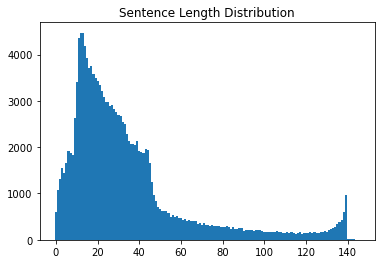

In [61]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


댓글이다 보니 짧은 리뷰들이 많은 것을 확인할 수 있습니다. 

In [62]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        sen = str(sen)
        if len(sen) == length:
            print(sen)
            print('\n')
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

아


잼


1


4


4


굿


짱


휴


.


1


굿


음


?


?


ㅎ


굿


ㅋ


굿


즐


♥


굳


ㅋ


네


ㅎ


ㅋ


굿


ㅇ


k


.


굿


굿


굳


ㅠ


?


1


ㅋ


굿


쒯


굿


굿


굳


♬


굿


토


ㅋ


ㅋ


굿


ㅋ


굿


O


똥


ㅎ


.


굿


ㅎ


짱


굳


굿


굿


짱


?


z


굿


짱


음


굳


ㅇ


헐


굳


굳


굿


굿


굿


삼


꽝


굿


굿


굿


굿


ㅎ


굳


굿


4


!


?


ㅎ


1


굳


.


ㅎ


풉


아


굿


똥


ㅅ


왜


ㄴ


굳


쉣


봐


z




In [63]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)
        

Outlier Index: 4
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46


그래프로 봤을때도 50대부터 급격하게 빈도수가 줄어드는 것을 확인할 수 있었는데 다시 한번 확인할 수 있는 명령어 입니다.

약 47 길이 이상의 문장의 경우 빈도수가 확연히 줄여들어 1500의 빈도수 보다 낮아짐을 확인할 수 있습니다.



In [64]:
check_sentence_with_length(raw, 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"


"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"


"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"




In [50]:
check_sentence_with_length(raw, 144)

"상처투성이인 한국인을 위하여 어제는 추기경님이 계셨고 오늘은 교황님께서 치유하시고 가셨습니다. "" 고난이 나를 찾을때 피하고 싶은 내마음은""하시며 노래부르실때는 한 인간으로서 사제로서 격었을 그분의 고난에 눈물이 흐릅니다. 이땅에 이런어른 더안계시나요"


"이제 어른들이 어떻게 하면 좋을까? 라는 대사에서 느껴지는 무책임. 담임이 자신의 딸에게 ""무책임? 그런 건 몰라!"" 에서 느껴지는 이중적인 모습에 소름 돋았다. 서바이벌 게임을 통해 그려진 그림 또한 실제 학급 모습과 크게 다르지 않다는 생각도..b"


"연출은 물론 배우들의 연기력 등 모든것이 완벽한 영화.모건 프리먼의 목소리가 영화의 몰입도를 더욱 높였다.""태평양이 내 꿈에서처럼 푸르기를 희망한다.나는 희망한다.""이 대사가 너무 좋았다ㅠ희망이라는 추상적인 명사에 대해 다시 생각하게되는 계기가 되었다"


"윤시윤,서재희역할 너무 머찌고 연기짱이였습니다.정말 몰입해서 잘 봤어요. 윤시윤배우의 가능성이 엿보이고, 이지아씨랑 연기호흡도 너무 좋았습니다. 어려운 상황에 좋은 작품 감동 적입니다. 이제 마지막회만 보면 ""나도꽃""다시보기정복완료.이지아,윤시윤 짱짱"


"그렇게 빵 터질만한 웃음도, 감동도 없었던 기억의 영화이지만... 다 필요 없다. 오로지 차이코프스키, 바이올린, 바이올린 협주곡 D장조 35번. 마지막 그 장면. 오로지 그것만이 모든 것을 감싼다. ""레아를 미치게 한건 바로 우리야."" 다시 듣고싶다"


"어른의 탈을 쓴 ""어린이들""의 이야기! 고민없이 등떠밀려 결혼하고, 육아와 일과 권태에 지쳐, 헛된 돌파구만 찾는 남녀들! 자신의 서러움만 외치다가, 남의 떡에 의지해보지만, 정작 모험앞에선 도망쳐버리지. 결혼의 가치와 허망함을 동시에 보여준 작품~!"


"괜찮은 영화 제목은 글쎄 진부한 미녀와 야수 스토리 속에는 러브스토리만이 아닌 서로를 만남으로써 자신의 모습을 찾게 된다. 여주인공이 선생을 관두면서 꼬맹이한테 한 말이 인상 깊다. ""살다 보면 멋진 사람을 

최대 길이인 146와 144길이의 가진 리뷰들입니다. 

위에서 언급했듯이 

일단 이번 리뷰에서는 수가 적은 긴 데이터는 제외하고 길이가 46인 데이터까지 학습에 사용하도록 하겠습니다.

일단 set을 통해서 중복을 제외하겠습니다.

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


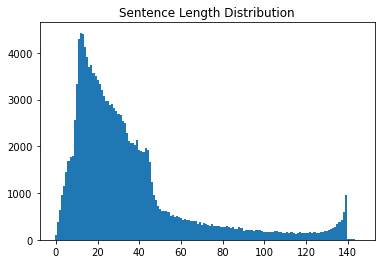

In [65]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


150000개의 데이터에서 중복을 줄이자 146183를 얻을 수 있었습니다.

지나치게 짧거나 긴 문장은 제외하고 5~46의 데이터만 사용하겠습니다.

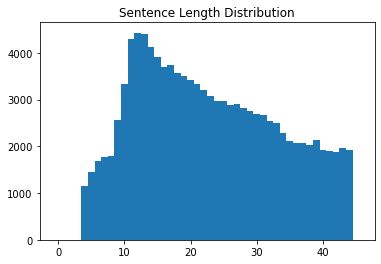

In [66]:
max_len = 46
min_len = 5

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(str(s)) < max_len) & (len(str(s)) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


46개를 사용했을때의 분포는 위와 같습니다. 

단 지금까지는 train data의 'document'만 가지고 데이터를 분할했기때문에 다시 label과 결합하기는 불편합니다.

그렇기때문에 다시 원본 데이터를 가져와서 길이가 5~46인것을 분할하는것이 더 나을거같다고 판단하여 다시 데이터를 가져왔습니다.

중복도 다시 제거합니다.

In [67]:


train_data = train_data.drop_duplicates(subset = 'document', keep = 'last')
test_data = test_data.drop_duplicates(subset = 'document', keep = 'last')

print(len(train_data))
print(len(test_data))

146182
49157


In [70]:
max_len = 46
min_len = 5

train_data = train_data[train_data['document'].map(len) <= max_len]
train_data = train_data[train_data['document'].map(len) > min_len]

test_data = test_data[test_data['document'].map(len) <= max_len]
test_data = test_data[test_data['document'].map(len) > min_len]


print(len(train_data))
print(len(test_data))

112989
37878


총 train_data를 112989개, test 데이터를 37878개까지 전처리 했습니다.

In [71]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [72]:
test_data

,id,document,label
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [73]:
X_train = train_data['document'].tolist()
y_train = train_data['label']

X_test  = test_data['document'].tolist()
y_test = test_data['label']

# SentencePiece 모델 학습

In [77]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in X_train:   # 이전 스텝에서 정제했던 네이버 corpus를 활용함. 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_naver_movie_rating_5_46 --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


-rw-r--r-- 1 ssac4 ssac4 375578  4월 21 20:59 korean_spm.model
-rw-r--r-- 1 ssac4 ssac4 375602  4월 21 21:10 korean_spm_naver_movie_rating_5_46.model
-rw-r--r-- 1 ssac4 ssac4 145018  4월 21 21:10 korean_spm_naver_movie_rating_5_46.vocab
-rw-r--r-- 1 ssac4 ssac4 145018  4월 21 20:59 korean_spm.vocab


## Test

In [78]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_naver_movie_rating_5_46.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentbence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1689, 10, 430, 16, 1553, 10, 181, 14, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## SentencePiece tokenizer 함수 작성 

In [79]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_naver_movie_rating_5_46.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word


In [83]:
#sp_tokenize(s, corpus) 테스트

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 485 2928   15 1038 2090    4    0    0    0    0]
 [1413 2067  237  506   10    3   17 7901  753    8]]


## SentencePiece 모델 학습

In [132]:
train_tensor, train_word_index, train_index_word = sp_tokenize(s, X_train)
test_tensor, test_word_index , test_index_word = sp_tokenize(s, X_test)

In [133]:
print(train_tensor.shape)
print(y_train.shape, '\n')
print(test_tensor.shape)
print(y_test.shape)

(112989, 44)
(112989,) 

(37878, 43)
(37878,)


## train,val 데이터 분리

sklearn의 train_test_split을 통해서 train데이터에서 train데이터와 valdataion data를 분류하였습니다.

In [110]:
from sklearn.model_selection import train_test_split


partial_x_train, x_val, partial_y_train, y_val  = train_test_split(train_tensor,
                                                             y_train,
                                                            test_size = 0.2,
                                                            random_state = 5)

print('validation set :',len(x_val), 'validation set을 제외한 나머지:',len(partial_x_train))

validation set : 22598 validation set을 제외한 나머지: 90391


<AxesSubplot:xlabel='label'>

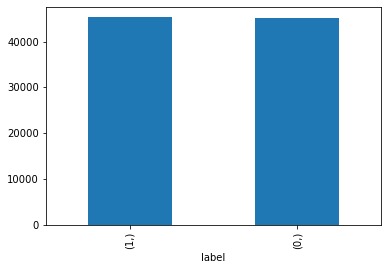

In [111]:
pd.DataFrame(partial_y_train).value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='label'>

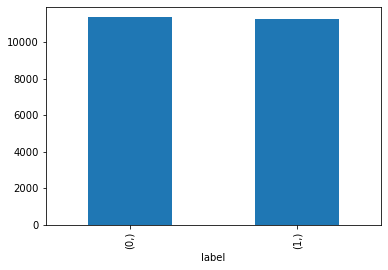

In [112]:
pd.DataFrame(y_val).value_counts().plot(kind = 'bar')

## 모델링

In [119]:
word_vector_dim = 16

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(32, return_sequences = True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.SpatialDropout1D(0.4))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 32)          0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           33        
Total params: 134,305
Trainable params: 134,305
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              


In [121]:
epochs= 6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_RNN = model_RNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose= 1)


Epoch 1/6
354/354 [==============================] - 2s 6ms/step - loss: 0.5028 - accuracy: 0.7519 - val_loss: 0.4140 - val_accuracy: 0.8097
Epoch 2/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3826 - accuracy: 0.8317 - val_loss: 0.3975 - val_accuracy: 0.8154
Epoch 3/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3628 - accuracy: 0.8390 - val_loss: 0.3969 - val_accuracy: 0.8176
Epoch 4/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3535 - accuracy: 0.8425 - val_loss: 0.4094 - val_accuracy: 0.8169
Epoch 5/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3459 - accuracy: 0.8450 - val_loss: 0.3925 - val_accuracy: 0.8183
Epoch 6/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3369 - accuracy: 0.8478 - val_loss: 0.4097 - val_accuracy: 0.8181


# 결과 확인 및 시각화

In [122]:
model_RNN.evaluate(test_tensor, y_test, verbose = 2)

1184/1184 - 2s - loss: 0.4123 - accuracy: 0.8117


[0.4123239815235138, 0.8116562366485596]

test 데이터에 대해서 약 81%의 성능을 보여주었습니다.

In [123]:
history_RNN_dict = history_RNN.history
print(history_RNN_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


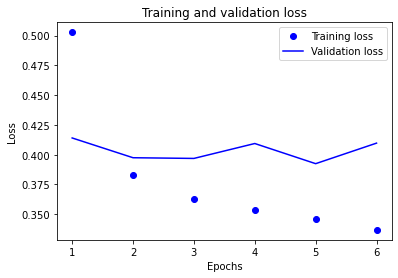

In [124]:
acc = history_RNN_dict['accuracy']
val_acc = history_RNN_dict['val_accuracy']
loss = history_RNN_dict['loss']
val_loss = history_RNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

6 epoch만 해도 validation loss가 더 이상 감소하지않고 횡보하기 때문에 학습을 멈추었습니다.

# SentencePiece의 다른 옵션 사용 -1 

일단 저희는 리뷰의 길이를 상당히 줄였기 때문에 vocab_size를 4000으로 줄여보도록 하겠습니다.

In [126]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 4000

with open(temp_file, 'w') as f:
    for row in X_train:   # 이전 스텝에서 정제했던 네이버 corpus를 활용함. 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_naver_movie_rating_5_46_4000 --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


-rw-r--r-- 1 ssac4 ssac4 375578  4월 21 20:59 korean_spm.model
-rw-r--r-- 1 ssac4 ssac4 298590  4월 21 21:48 korean_spm_naver_movie_rating_5_46_4000.model
-rw-r--r-- 1 ssac4 ssac4  64453  4월 21 21:48 korean_spm_naver_movie_rating_5_46_4000.vocab
-rw-r--r-- 1 ssac4 ssac4 298585  4월 21 21:48 korean_spm_naver_movie_rating_5_46.model
-rw-r--r-- 1 ssac4 ssac4  64453  4월 21 21:48 korean_spm_naver_movie_rating_5_46.vocab
-rw-r--r-- 1 ssac4 ssac4 145018  4월 21 20:59 korean_spm.vocab


In [136]:
s_4000 = spm.SentencePieceProcessor()
s_4000.Load('korean_spm_naver_movie_rating_5_46_4000.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentbence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[2158, 8, 466, 16, 1779, 8, 96, 12, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [137]:
train_tensor, train_word_index, train_index_word = sp_tokenize(s_4000, X_train)
test_tensor, test_word_index , test_index_word = sp_tokenize(s_4000, X_test)

In [138]:
print(train_tensor.shape)
print(y_train.shape, '\n')
print(test_tensor.shape)
print(y_test.shape)

(112989, 44)
(112989,) 

(37878, 43)
(37878,)


## train,val 데이터 분리

sklearn의 train_test_split을 통해서 train데이터에서 train데이터와 valdataion data를 분류하였습니다.

In [139]:
from sklearn.model_selection import train_test_split


partial_x_train, x_val, partial_y_train, y_val  = train_test_split(train_tensor,
                                                             y_train,
                                                            test_size = 0.2,
                                                            random_state = 5)

print('validation set :',len(x_val), 'validation set을 제외한 나머지:',len(partial_x_train))

validation set : 22598 validation set을 제외한 나머지: 90391


<AxesSubplot:xlabel='label'>

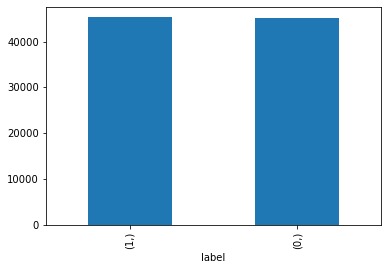

In [140]:
pd.DataFrame(partial_y_train).value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='label'>

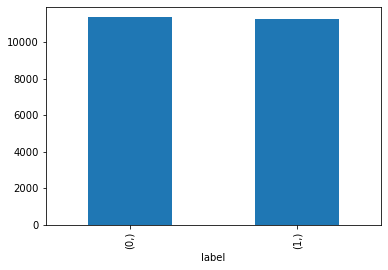

In [112]:
pd.DataFrame(y_val).value_counts().plot(kind = 'bar')

## 모델링

In [141]:
word_vector_dim = 16

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(32, return_sequences = True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.SpatialDropout1D(0.4))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 32)          0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           33        
Total params: 70,305
Trainable params: 70,305
Non-trainable params: 0
_________________________________________________________________


In [142]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              


In [143]:
epochs= 6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_RNN = model_RNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose= 1)


Epoch 1/6
354/354 [==============================] - 2s 5ms/step - loss: 0.5137 - accuracy: 0.7376 - val_loss: 0.4311 - val_accuracy: 0.7962
Epoch 2/6
354/354 [==============================] - 2s 5ms/step - loss: 0.4080 - accuracy: 0.8124 - val_loss: 0.4195 - val_accuracy: 0.8010
Epoch 3/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3963 - accuracy: 0.8169 - val_loss: 0.4122 - val_accuracy: 0.8041
Epoch 4/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3894 - accuracy: 0.8197 - val_loss: 0.4082 - val_accuracy: 0.8051
Epoch 5/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3824 - accuracy: 0.8216 - val_loss: 0.4077 - val_accuracy: 0.8062
Epoch 6/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3763 - accuracy: 0.8240 - val_loss: 0.4127 - val_accuracy: 0.8036


# 결과 확인 및 시각화

In [144]:
model_RNN.evaluate(test_tensor, y_test, verbose = 2)

1184/1184 - 2s - loss: 0.4135 - accuracy: 0.8035


[0.4134635031223297, 0.8034858703613281]

test 데이터에 대해서 약 80%의 성능을 보여주었습니다. 즉 소폭 하락하였습니다.

In [145]:
history_RNN_dict = history_RNN.history
print(history_RNN_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


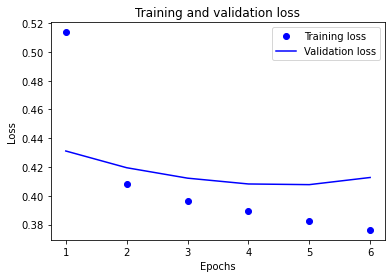

In [146]:
acc = history_RNN_dict['accuracy']
val_acc = history_RNN_dict['val_accuracy']
loss = history_RNN_dict['loss']
val_loss = history_RNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# SentencePiece의 다른 옵션 사용 - 2 

지금까지는 model type을 디폴트인 unigram을 사용하졌지만 bpe를 사용해보도록 하겠습니다.  

In [165]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000
model_type = "bpe"

with open(temp_file, 'w') as f:
    for row in X_train:   # 이전 스텝에서 정제했던 네이버 corpus를 활용함. 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_naver_movie_rating_bpe --model_type=bpe --vocab_size={} '.format(temp_file, vocab_size))    

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


-rw-r--r-- 1 ssac4 ssac4 375578  4월 21 20:59 korean_spm.model
-rw-r--r-- 1 ssac4 ssac4 298590  4월 21 21:48 korean_spm_naver_movie_rating_5_46_4000.model
-rw-r--r-- 1 ssac4 ssac4  64453  4월 21 21:48 korean_spm_naver_movie_rating_5_46_4000.vocab
-rw-r--r-- 1 ssac4 ssac4 298585  4월 21 21:48 korean_spm_naver_movie_rating_5_46.model
-rw-r--r-- 1 ssac4 ssac4  64453  4월 21 21:48 korean_spm_naver_movie_rating_5_46.vocab
-rw-r--r-- 1 ssac4 ssac4 370547  4월 21 22:04 korean_spm_naver_movie_rating_bpe.model
-rw-r--r-- 1 ssac4 ssac4 115748  4월 21 22:04 korean_spm_naver_movie_rating_bpe.vocab
-rw-r--r-- 1 ssac4 ssac4 145018  4월 21 20:59 korean_spm.vocab


In [167]:
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('korean_spm_naver_movie_rating_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentbence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[2158, 8, 466, 16, 1779, 8, 96, 12, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [168]:
train_tensor, train_word_index, train_index_word = sp_tokenize(s_bpe, X_train)
test_tensor, test_word_index , test_index_word = sp_tokenize(s_bpe, X_test)

In [169]:
print(train_tensor.shape)
print(y_train.shape, '\n')
print(test_tensor.shape)
print(y_test.shape)

(112989, 39)
(112989,) 

(37878, 36)
(37878,)


## train,val 데이터 분리

sklearn의 train_test_split을 통해서 train데이터에서 train데이터와 valdataion data를 분류하였습니다.

In [170]:
from sklearn.model_selection import train_test_split


partial_x_train, x_val, partial_y_train, y_val  = train_test_split(train_tensor,
                                                             y_train,
                                                            test_size = 0.2,
                                                            random_state = 5)

print('validation set :',len(x_val), 'validation set을 제외한 나머지:',len(partial_x_train))

validation set : 22598 validation set을 제외한 나머지: 90391


<AxesSubplot:xlabel='label'>

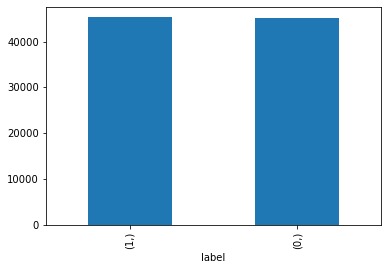

In [171]:
pd.DataFrame(partial_y_train).value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='label'>

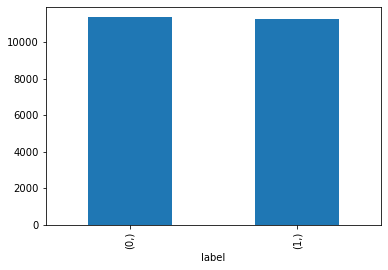

In [112]:
pd.DataFrame(y_val).value_counts().plot(kind = 'bar')

## 모델링

In [172]:
word_vector_dim = 16

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(32, return_sequences = True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.SpatialDropout1D(0.4))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, None, 32)          0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           33        
Total params: 134,305
Trainable params: 134,305
Non-trainable params: 0
_________________________________________________________________


In [173]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              


In [174]:
epochs= 6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_RNN = model_RNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose= 1)


Epoch 1/6
354/354 [==============================] - 2s 5ms/step - loss: 0.5044 - accuracy: 0.7514 - val_loss: 0.4135 - val_accuracy: 0.8106
Epoch 2/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3825 - accuracy: 0.8300 - val_loss: 0.4042 - val_accuracy: 0.8146
Epoch 3/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3628 - accuracy: 0.8384 - val_loss: 0.3981 - val_accuracy: 0.8149
Epoch 4/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3519 - accuracy: 0.8419 - val_loss: 0.4036 - val_accuracy: 0.8134
Epoch 5/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3418 - accuracy: 0.8447 - val_loss: 0.4026 - val_accuracy: 0.8144
Epoch 6/6
354/354 [==============================] - 2s 5ms/step - loss: 0.3313 - accuracy: 0.8484 - val_loss: 0.4055 - val_accuracy: 0.8139


# 결과 확인 및 시각화

In [175]:
model_RNN.evaluate(test_tensor, y_test, verbose = 2)

1184/1184 - 2s - loss: 0.4056 - accuracy: 0.8137


[0.4055664539337158, 0.8137247562408447]

test 데이터에 대해서 약 81%의 성능을 보여주었습니다. 즉 거의 비슷한 성능을 냈습니다.

In [176]:
history_RNN_dict = history_RNN.history
print(history_RNN_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


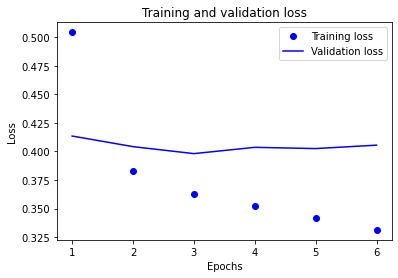

In [177]:
acc = history_RNN_dict['accuracy']
val_acc = history_RNN_dict['val_accuracy']
loss = history_RNN_dict['loss']
val_loss = history_RNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

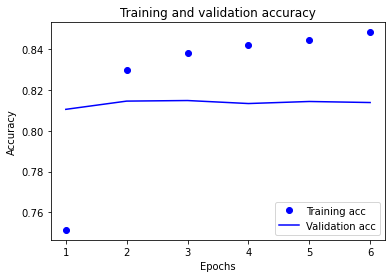

In [178]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


그래도 val_los와 val_acc의 더 변동성이 작다는 점에서 의의를 찾을수 있을것 같습니다.

# 소고

사실 이전에 했던 데이터를 다시 이용했는데 이전에는 Word2Vec 임베딩을 활용하면 86%까지도 test 정확도를 상승시킬수있었습니다.

하지만 이번에는 그것에 비해서 성능이 떨어지는 모습을 보였습니다. 

(단 그 모델과 사용한 데이터의 길이가 다르므로 정확한 비교는 불가능합니다. 그때는 한글로 쓴것이 아닌 외래어, 특수문자 등은 모두 제거하여 전처리를 마친후에 토큰화 시켜놓고 그 후 토큰의 길이를 통해 데이터를 정제했고 이번은 그런 전처리 없이 바로 한글, 영어,특수문자로 섞여있는 데이터에 바로 sentencePiece 토크나이저를 사용하였습니다.) 

아무래도 여러 언어에 통합적으로 사용할 수 있는 모델이다 보니 더 제네럴하고 쉽게 사용할 수 있지만

한국어어로 전처리를 한 모델에 비해서 단독적인 성능은 떨어질 수 있는것같습니다.

공부하면서 의문이 들었던게 sentencepiece가 unigram 방법과 bpe 방식이 구체적으로 더 어떻게 다른지 이해가 잘 되지않았습니다.

일단 unigram 방식은 [논문 링크](https://arxiv.org/abs/1804.10959)에서 Unigram Language Model Tokenizer을 쓰고

bpe은 [논문 링크](https://www.aclweb.org/anthology/P16-1162/)을 활용한 차이같은데 구체적으론 잘 모르겠습니다..

내일 다른 분들과 한번 토론하면서 이야기를 해보고 싶은 주제여서 논의해보고 싶습니다. 

## 루브릭

|평가문항|상세기준|
|--|--|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|